In [36]:
import pathlib

import requests
from pathlib import Path, PosixPath
import os
import pandas as pd

In [4]:
print(f"Note: data written to {os.getcwd()}/data")

Note: data written to /home/kh701/pycharm/mm-lego/data


In [ ]:
download_urls = { 
    "brca":
        {
            "survival": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FBRCA_survival.txt", 
            "clinical": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FBRCA_clinicalMatrix",
            "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz",
            "rnaseq": None,
            "mut": None,
        }
}

In [5]:
data_link =  "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FBLCA_survival.txt"

survival_urls = { 
    "blca": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FBLCA_survival.txt", 
    "brca": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FBRCA_survival.txt", 
    "kirp": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FKIRP_survival.txt", 
    "ucec": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FUCEC_survival.txt"
}

clinical_urls = { 
    "brca": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FBRCA_clinicalMatrix"
}


Note the recommended way to use the different survival tasks: 
https://www.cell.com/action/showFullTableImage?isHtml=true&tableId=tbl3&pii=S0092867418302290

In [320]:
# download and write text file

survival_dir = Path("data/tcga/omic/xena/survival/")
clinical_dir = Path("data/tcga/omic/xena/clinical/")
def download(url: str, save_path: Path, rewrite: bool = False) -> None:
    response = requests.get(url, stream=True)
    assert type(save_path) == PosixPath, f"save_path must be a Path object but got {type(save_path)}"
    
    print(response)
    
    if not os.path.exists(save_path.parent): 
        os.makedirs(save_path.parent, exist_ok=True)
    
    if os.path.exists(save_path) and not rewrite:
        print(f"File {save_path} already exists. Skipping download.")
        return None
    else:
        with open(save_path, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=1024):
                fd.write(chunk)

# decompress .gz file
def decompress_gz(file_path: Path) -> None:
    assert file_path.suffix == ".gz", f"File must be a .gz file but got {file_path.suffix}"
    os.system(f"gunzip -f {file_path}")


for dataset, url in survival_urls.items():
    download(url=url, save_path=survival_dir.joinpath(f"{dataset}_survival.txt"))

for dataset, url in clinical_urls.items():
    download(url=url, save_path=clinical_dir.joinpath(f"{dataset}_clinical.txt"))


# download(url = data_link, save_path=target_dir.joinpath("blca_survival.txt"))


<Response [200]>
File data/tcga/omic/xena/survival/blca_survival.txt already exists. Skipping download.
<Response [200]>
File data/tcga/omic/xena/survival/brca_survival.txt already exists. Skipping download.
<Response [200]>
File data/tcga/omic/xena/survival/kirp_survival.txt already exists. Skipping download.
<Response [200]>
File data/tcga/omic/xena/survival/ucec_survival.txt already exists. Skipping download.
<Response [200]>
File data/tcga/omic/xena/clinical/brca_clinical.txt already exists. Skipping download.


#### SurvPath preprocessing steps
1. drop duplicate case IDs
2. check if clinical data is available


BRCA: n=869

https://github.com/mahmoodlab/SurvPath/blob/fe4a97bf8fc57925dc81ff930ef7e1d9b2bbc83a/datasets/dataset_survival.py#L485

In [7]:
# general survival reference
gs = pd.read_csv("../mm-health-bench/data/tcga/omic/tcga_brca_all_clean.csv.zip", compression="zip")

print(f"Dropping duplicates: {gs['case_id'].duplicated().sum()}")

gs = gs.drop_duplicates(subset="case_id", keep="first")

Dropping duplicates: 66


In [8]:
gs.isna().sum()

Unnamed: 0    0
case_id       0
slide_id      0
age           0
site          0
             ..
TP53_mut      0
TTN_mut       0
USH2A_mut     0
ZFHX4_mut     0
RAS_mut       0
Length: 2922, dtype: int64

In [9]:
df["sample"]

NameError: name 'df' is not defined

In [10]:
dfc.columns

NameError: name 'dfc' is not defined

In [11]:
df= pd.read_csv(survival_dir.joinpath("brca_survival.txt"), sep="\t")
# clinical data
dfc = pd.read_csv(clinical_dir.joinpath("brca_clinical.txt"), sep="\t")
# filter duplicates, keep first

print("RAW")
print(f"survival: {df.shape}, clinical: {dfc.shape}")

# filter slide overlap
case_length = 12 # first 12 digits of WSI filename indicate the case number
dir_name = "/auto/archive/tcga/tcga/wsi/brca/"
slide_patients = pd.Series([slide[:case_length] for slide in os.listdir(dir_name) if slide.endswith(".svs")])

print(f"Dropping survival cases w/o slides: {df[~df['_PATIENT'].isin(slide_patients)].shape[0]}")
print(f"Dropping clinical cases w/o slides: {dfc[~dfc['_PATIENT'].isin(slide_patients)].shape[0]}")

# filter patients without multiomic data



df = df[df["_PATIENT"].isin(slide_patients)]
dfc = dfc[dfc["_PATIENT"].isin(slide_patients)]

print(f"Dropping duplicates: {df['_PATIENT'].duplicated().sum()} from survival data") 
print(f"Dropping duplicates: {dfc['_PATIENT'].duplicated().sum()} from clinical data")

df = df.drop_duplicates(subset="_PATIENT", keep="first")
dfc = dfc.drop_duplicates(subset="_PATIENT", keep="first")

# drop DSS nans
df = df[~df["DSS"].isna()]
df["DSS"] = df["DSS"].astype(int)



print("FILTERED")
print(f"survival: {df.shape}, clinical: {dfc.shape}")

RAW
survival: (1236, 11), clinical: (1247, 194)
Dropping survival cases w/o slides: 154
Dropping clinical cases w/o slides: 161
Dropping duplicates: 127 from survival data
Dropping duplicates: 131 from clinical data
FILTERED
survival: (937, 11), clinical: (955, 194)


In [108]:
df[df["OS.time"] != df["DFI.time"]]

,sample,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
3,TCGA-3C-AALK-01,TCGA-3C-AALK,0,1448.0,0,1448.0,NaN,NaN,0,1448.0,NaN
5,TCGA-5L-AAT0-01,TCGA-5L-AAT0,0,1477.0,0,1477.0,NaN,NaN,0,1477.0,NaN
6,TCGA-5L-AAT1-01,TCGA-5L-AAT1,0,1471.0,0,1471.0,NaN,NaN,0,1471.0,NaN
7,TCGA-5T-A9QA-01,TCGA-5T-A9QA,0,303.0,0,303.0,NaN,NaN,0,303.0,NaN
16,TCGA-A1-A0SK-01,TCGA-A1-A0SK,1,967.0,1,967.0,NaN,NaN,1,967.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1214,TCGA-PL-A8LY-01,TCGA-PL-A8LY,0,8.0,0,8.0,NaN,NaN,0,8.0,NaN
1215,TCGA-PL-A8LZ-01,TCGA-PL-A8LZ,0,302.0,0,302.0,NaN,NaN,0,302.0,NaN
1226,TCGA-UL-AAZ6-01,TCGA-UL-AAZ6,0,518.0,0,518.0,NaN,NaN,0,518.0,NaN
1227,TCGA-UU-A93S-01,TCGA-UU-A93S,1,116.0,1,116.0,NaN,NaN,1,116.0,NaN


In [123]:
dfc.head()

,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NaN,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NaN
2,TCGA-3C-AALJ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,NaN,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NaN
3,TCGA-3C-AALK-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1a19e068-d213-41ef-aebb-104017a883cc,NaN,TCGA-3C-AALK-01A-11D-A41E-01,TCGA-3C-AALK-01,NaN,1a19e068-d213-41ef-aebb-104017a883cc,TCGA-3C-AALK-01A-11D-A41E-01,NaN
4,TCGA-4H-AAAK-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,NaN,TCGA-4H-AAAK-01A-12D-A41E-01,TCGA-4H-AAAK-01,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,TCGA-4H-AAAK-01A-12D-A41E-01,NaN
5,TCGA-5L-AAT0-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,32e61645-eb89-49f7-9876-85b1497c7e42,NaN,TCGA-5L-AAT0-01A-12D-A41E-01,TCGA-5L-AAT0-01,NaN,32e61645-eb89-49f7-9876-85b1497c7e42,TCGA-5L-AAT0-01A-12D-A41E-01,NaN


In [12]:
sp_clinical = pd.read_csv("../SurvPath/datasets_csv/clinical_data/tcga_brca_clinical.csv")
sp_survival = pd.read_csv("../SurvPath/datasets_csv/metadata/tcga_brca.csv")
print("RAW")
print(f"survival: {sp_survival.shape}, clinical: {sp_clinical.shape}")
print(f"Dropping duplicates: {sp_survival['case_id'].duplicated().sum()} from survival data")
print(f"Dropping duplicates: {sp_clinical['case_id'].duplicated().sum()} from clinical data")
sp_survival = sp_survival.drop_duplicates(subset="case_id", keep="first")
sp_clinical = sp_clinical.drop_duplicates(subset="case_id", keep="first")
print("FILTERED")
print(f"survival: {sp_survival.shape}, clinical: {sp_clinical.shape}")

RAW
survival: (931, 14), clinical: (1108, 5)
Dropping duplicates: 60 from survival data
Dropping duplicates: 7 from clinical data
FILTERED
survival: (871, 14), clinical: (1101, 5)


In [13]:
# sp_survival
case_length = 12 # first 12 digits of WSI filename indicate the case number
dir_name = "/auto/archive/tcga/tcga/wsi/brca/"

slide_patients = pd.Series([slide[:case_length] for slide in os.listdir(dir_name) if slide.endswith(".svs")])

df["_PATIENT"].isin(slide_patients).sum()

# df[df["_PATIENT"].isin(slide_patients)]
# for slide in os.listdir(dir_name): 
#     case_id = slide[:case_length]
    # if case_id not in sp_survival["case_id"].values: 
    #     print(f"Case ID {case_id} not in survival data")
# df["_PATIENT"].str.len().unique()

937

In [14]:
# check slide availability
df[df["_PATIENT"].str.contains("TCGA_OL_A5RZ")]

,sample,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction


In [15]:
master = df.merge(dfc, left_on="_PATIENT", right_on="_PATIENT", how="left")

master[~master["_PATIENT"].isin(sp_survival["case_id"])]

,sample,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
7,TCGA-A1-A0SB-01,TCGA-A1-A0SB,0,259.0,0,259.0,0.0,259.0,0,259.0,...,TCGA-A1-A0SB-01A-11D-A142-09,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,NaN,TCGA-A1-A0SB-01A-11D-A141-01,TCGA-A1-A0SB-01,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,TCGA-A1-A0SB-01A-11D-A141-01,NaN
9,TCGA-A1-A0SE-01,TCGA-A1-A0SE,0,1321.0,0,1321.0,0.0,1321.0,0,1321.0,...,TCGA-A1-A0SE-01A-11D-A099-09,TCGA-A1-A0SE-01,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01,TCGA-A1-A0SE-01A-11D-A087-01,NaN,TCGA-A1-A0SE-01A-11R-A084-07,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01A-11D-A087-01,TCGA-A1-A0SE-01
14,TCGA-A1-A0SK-01,TCGA-A1-A0SK,1,967.0,1,967.0,NaN,NaN,1,967.0,...,TCGA-A1-A0SK-01A-12D-A099-09,TCGA-A1-A0SK-01,a63583ca-0ef2-4417-b435-5f3a6951d0c2,TCGA-A1-A0SK-01,TCGA-A1-A0SK-01A-12D-A087-01,NaN,TCGA-A1-A0SK-01A-12R-A084-07,a63583ca-0ef2-4417-b435-5f3a6951d0c2,TCGA-A1-A0SK-01A-12D-A087-01,TCGA-A1-A0SK-01
77,TCGA-A2-A0YI-01,TCGA-A2-A0YI,0,1505.0,0,1505.0,0.0,1505.0,0,1505.0,...,TCGA-A2-A0YI-01A-31D-A10M-09,TCGA-A2-A0YI-01,4de3ad78-68e4-4ab9-b1f6-eb0666140761,TCGA-A2-A0YI-01,TCGA-A2-A0YI-01A-31D-A10L-01,NaN,TCGA-A2-A0YI-01A-31R-A10J-07,4de3ad78-68e4-4ab9-b1f6-eb0666140761,TCGA-A2-A0YI-01A-31D-A10L-01,TCGA-A2-A0YI-01
97,TCGA-A2-A3KD-01,TCGA-A2-A3KD,0,1206.0,0,1206.0,NaN,NaN,0,1206.0,...,NaN,NaN,8a224dc6-632b-418b-bd5e-bcefc8ad049e,NaN,TCGA-A2-A3KD-01A-12D-A20R-01,TCGA-A2-A3KD-01,NaN,8a224dc6-632b-418b-bd5e-bcefc8ad049e,TCGA-A2-A3KD-01A-12D-A20R-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,TCGA-OL-A5RX-01,TCGA-OL-A5RX,0,878.0,0,878.0,0.0,878.0,0,878.0,...,NaN,NaN,650c0c98-4432-4e9a-9e83-4ad8a7a0d628,NaN,TCGA-OL-A5RX-01A-11D-A28A-01,TCGA-OL-A5RX-01,NaN,650c0c98-4432-4e9a-9e83-4ad8a7a0d628,TCGA-OL-A5RX-01A-11D-A28A-01,NaN
899,TCGA-OL-A5RY-01,TCGA-OL-A5RY,0,752.0,0,752.0,0.0,752.0,0,752.0,...,NaN,NaN,2407816a-86e7-4094-a028-e81c0cda5448,NaN,TCGA-OL-A5RY-01A-21D-A28A-01,TCGA-OL-A5RY-01,NaN,2407816a-86e7-4094-a028-e81c0cda5448,TCGA-OL-A5RY-01A-21D-A28A-01,NaN
900,TCGA-OL-A5RZ-01,TCGA-OL-A5RZ,0,679.0,0,679.0,0.0,679.0,0,679.0,...,NaN,NaN,fc8c0c74-cd1b-4bc7-ab1d-568d302c5719,NaN,TCGA-OL-A5RZ-01A-11D-A28A-01,TCGA-OL-A5RZ-01,NaN,fc8c0c74-cd1b-4bc7-ab1d-568d302c5719,TCGA-OL-A5RZ-01A-11D-A28A-01,NaN
901,TCGA-OL-A5S0-01,TCGA-OL-A5S0,0,620.0,0,620.0,0.0,620.0,0,620.0,...,NaN,NaN,f6e02767-7522-4895-bc70-c7de6b1796ab,NaN,TCGA-OL-A5S0-01A-11D-A28A-01,TCGA-OL-A5S0-01,NaN,f6e02767-7522-4895-bc70-c7de6b1796ab,TCGA-OL-A5S0-01A-11D-A28A-01,NaN


In [16]:
# check_col
col = "mtsttc_brst_crcnm_mmnhstchmstry_prgstrn_rcptr_pstv_fndng_scl_typ"

# cancidates: "icd_10"

print(master[~master["_PATIENT"].isin(sp_survival["case_id"])][col].unique())
print(master[master["_PATIENT"].isin(sp_survival["case_id"])][col].unique())

[nan]
[nan '3 Point Scale' '4 Point Scale' 'Other Reporting Scale']


In [17]:
master[master["_PATIENT"].isin(sp_survival["case_id"])]

,sample,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
0,TCGA-3C-AALI-01,TCGA-3C-AALI,0,4005.0,0,4005.0,0.0,4005.0,0,4005.0,...,NaN,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NaN,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NaN
1,TCGA-3C-AALJ-01,TCGA-3C-AALJ,0,1474.0,0,1474.0,0.0,1474.0,0,1474.0,...,NaN,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,NaN,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NaN
2,TCGA-3C-AALK-01,TCGA-3C-AALK,0,1448.0,0,1448.0,NaN,NaN,0,1448.0,...,NaN,NaN,1a19e068-d213-41ef-aebb-104017a883cc,NaN,TCGA-3C-AALK-01A-11D-A41E-01,TCGA-3C-AALK-01,NaN,1a19e068-d213-41ef-aebb-104017a883cc,TCGA-3C-AALK-01A-11D-A41E-01,NaN
3,TCGA-4H-AAAK-01,TCGA-4H-AAAK,0,348.0,0,348.0,0.0,348.0,0,348.0,...,NaN,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,NaN,TCGA-4H-AAAK-01A-12D-A41E-01,TCGA-4H-AAAK-01,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,TCGA-4H-AAAK-01A-12D-A41E-01,NaN
4,TCGA-5L-AAT0-01,TCGA-5L-AAT0,0,1477.0,0,1477.0,NaN,NaN,0,1477.0,...,NaN,NaN,32e61645-eb89-49f7-9876-85b1497c7e42,NaN,TCGA-5L-AAT0-01A-12D-A41E-01,TCGA-5L-AAT0-01,NaN,32e61645-eb89-49f7-9876-85b1497c7e42,TCGA-5L-AAT0-01A-12D-A41E-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,TCGA-WT-AB44-01,TCGA-WT-AB44,0,883.0,0,883.0,0.0,883.0,0,883.0,...,NaN,NaN,77ea5b95-f8df-4fae-b271-182680c4a62a,NaN,TCGA-WT-AB44-01A-11D-A41E-01,TCGA-WT-AB44-01,NaN,77ea5b95-f8df-4fae-b271-182680c4a62a,TCGA-WT-AB44-01A-11D-A41E-01,NaN
933,TCGA-XX-A899-01,TCGA-XX-A899,0,467.0,0,467.0,0.0,467.0,0,467.0,...,NaN,NaN,8e339298-3e3c-4b31-96a9-a842e973e583,NaN,TCGA-XX-A899-01A-11D-A36I-01,TCGA-XX-A899-01,NaN,8e339298-3e3c-4b31-96a9-a842e973e583,TCGA-XX-A899-01A-11D-A36I-01,NaN
934,TCGA-XX-A89A-01,TCGA-XX-A89A,0,488.0,0,488.0,0.0,488.0,0,488.0,...,NaN,NaN,501a70d8-3932-49c0-aa13-774756fb89e3,NaN,TCGA-XX-A89A-01A-11D-A36I-01,TCGA-XX-A89A-01,NaN,501a70d8-3932-49c0-aa13-774756fb89e3,TCGA-XX-A89A-01A-11D-A36I-01,NaN
935,TCGA-Z7-A8R5-01,TCGA-Z7-A8R5,0,3287.0,0,3287.0,NaN,NaN,1,181.0,...,NaN,NaN,43c6d23b-2fcd-499e-82ef-10f15d8ede90,NaN,TCGA-Z7-A8R5-01A-42D-A41E-01,TCGA-Z7-A8R5-01,NaN,43c6d23b-2fcd-499e-82ef-10f15d8ede90,TCGA-Z7-A8R5-01A-42D-A41E-01,NaN


In [18]:
os.path.exists("../SurvPath/datasets_csv/clinical_data/tcga_brca_clinical.csv")

True

In [19]:
sp_clinical = pd.read_csv("../SurvPath/datasets_csv/clinical_data/tcga_brca_clinical.csv")
sp_survival = pd.read_csv("../SurvPath/datasets_csv/metadata/tcga_brca.csv")
print(f"survival: {sp_survival.shape}, clinical: {sp_clinical.shape}")

survival: (931, 14), clinical: (1108, 5)


In [20]:
# check survival data
sp_survival.drop_duplicates(subset="case_id", keep="first")

,Unnamed: 0,case_id,slide_id,age,site,survival_months,survival_months_dss,survival_months_pfi,censorship,censorship_dss,censorship_pfi,is_female,oncotree_code,train
0,0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,50.0,3C,133.500000,133.500000,133.500000,1,1,1,1.0,IDC,1.0
2,2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,62.0,3C,49.133333,49.133333,49.133333,1,1,1,1.0,IDC,1.0
4,4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,52.0,3C,48.266667,48.266667,48.266667,1,1,1,1.0,IDC,1.0
5,5,TCGA-4H-AAAK,TCGA-4H-AAAK-01Z-00-DX1.ABF1B042-1970-4E28-867...,50.0,4H,11.600000,11.600000,11.600000,1,1,1,1.0,ILC,1.0
6,6,TCGA-5L-AAT0,TCGA-5L-AAT0-01Z-00-DX1.5E171263-30BF-4C6B-88A...,42.0,5L,49.233333,49.233333,49.233333,1,1,1,1.0,ILC,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,926,TCGA-WT-AB44,TCGA-WT-AB44-01Z-00-DX1.B6ECEA7C-DA26-4B34-88C...,77.0,WT,29.433333,29.433333,29.433333,1,1,1,1.0,ILC,1.0
927,927,TCGA-XX-A899,TCGA-XX-A899-01Z-00-DX1.08FE27B7-73B8-4CE3-ACF...,46.0,XX,15.566667,15.566667,15.566667,1,1,1,1.0,ILC,1.0
928,928,TCGA-XX-A89A,TCGA-XX-A89A-01Z-00-DX1.671E2AD6-4D1A-4579-88C...,68.0,XX,16.266667,16.266667,16.266667,1,1,1,1.0,ILC,1.0
929,929,TCGA-Z7-A8R5,TCGA-Z7-A8R5-01Z-00-DX1.3BDB407F-514C-4131-B05...,61.0,Z7,109.566667,109.566667,6.033333,1,1,0,1.0,ILC,1.0


In [21]:
# check survival status
# df[df["DSS"] != df["OS"]]

In [22]:
#get overlap of _PATIENT between df and dfc
dfc["_PATIENT"].isin(df["_PATIENT"]).sum()

937

## Recreate curated omic data
- Mixture of clinical and omic variables

### Copy number variation

We are taking the thresholded gistic2 copy numbers from the Xena data hub. 

Description: 
TCGA breast invasive carcinoma (BRCA) thresholded gene-level copy number variation (CNV) estimated using the GISTIC2 method. Copy number profile was measured experimentally using whole genome microarray at a TCGA genome characterization center. Subsequently, GISTIC2 method was applied using the TCGA FIREHOSE pipeline to produce gene-level copy number estimates. GISTIC2 further thresholded the estimated values to -2,-1,0,1,2, representing homozygous deletion, single copy deletion, diploid normal copy, low-level copy number amplification, or high-level copy number amplification. Genes are mapped onto the human genome coordinates using UCSC xena HUGO probeMap. Reference to GISTIC2 method PMID:21527027.

Gisctic2.0 thresholded CNV meanings: 
* -2: Homozygous deletion. Both copies of the gene are deleted, which can lead to the loss of tumor suppressor gene function.
* -1: Single copy deletion. One copy of the gene is deleted, which might reduce the gene's function and could be significant if it's a tumor suppressor gene.
* 0: Neutral / No change. The gene has the expected number of copies, suggesting it might not be involved in the cancer process for this patient.
* 1: Low-level amplification. There is a slight increase in the number of copies of the gene, which could enhance the gene's function, potentially significant if the gene is an oncogene.
* 2: High-level amplification. There is a significant increase in the number of copies of the gene, strongly suggesting the gene's enhanced function could be driving the cancer process.

#### Download

In [54]:
download_dict = {
    "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz", 
    "rnaseq": None,
}

write_path = Path("data/tcga/omic/xena/cnv/brca_cnv.txt")
if download_dict["cnv"].endswith(".gz"):
    write_path = Path(str(write_path) + ".gz")

# download cnv data
download(save_path=write_path, url=download_dict["cnv"])

if write_path.suffix == ".gz":
    decompress_gz(write_path)

# Copy numbers variations
# cnv = pd.read_csv("data/tcga/omic/xena/cnv/brca_cnv.txt", sep="")

#### Load and preprocess from txt file

In [237]:
def load_cnv(): 
    
    cnv = pd.read_csv("data/tcga/omic/xena/cnv/brca_cnv.txt", sep="\t")
    # some basic reformatting
    
    cnv = cnv.T
    cnv.head()
    cnv.columns = cnv.iloc[0]
    cnv = cnv[1:] # drop first header
    # get case id as index (only first 12 digits)
    cnv.index = cnv.index.str[:12]
    # drop duplicates
    cnv = cnv[~cnv.index.duplicated(keep='first')]
    # set first row as header
    # sort alphabetically
    cnv = cnv.sort_index(axis=1)
    # filter out columns containing "|"
    # cnv = cnv.loc[:, ~cnv.columns.str.contains("\|")]
    
    # drop columns with all nans (if any)
    cnv = cnv.dropna(axis=1, how="all")
    cnv = cnv.dropna(axis=0, how="all")
    # # drop columns with only single value
    cnv = cnv.loc[:, cnv.nunique() > 1]
    
    # In line with other papers, we filter out the genes with a CNV=2 (high-level amplification) ratio of greater than 10%.
    cnv_dist = cnv.apply(lambda x: x.value_counts()/x.shape)
    copy_threshold = 0.1 # threshold for highest copy number values
    cnv_mask = cnv_dist.iloc[-1] > copy_threshold
    
    # alternative cnv mask - it would also make sense to filter out genes with CNV=-2 (homozygous deletion) ratio of greater than 10%.
    # cnv_mask = cnv_dist.iloc[-1] > 0.15 | cnv_dist.iloc[0] > 0.01
    
    cnv_filtered = cnv[cnv_mask.index[cnv_mask]]
    cnv_filtered.columns = [f"{col}_cnv" for col in cnv_filtered.columns]
    
    cnv_filtered, duplicate_cols = remove_duplicate_cols(cnv_filtered)
    return cnv_filtered, duplicate_cols
    
    
def remove_duplicate_cols(df):
    """
    Removes duplicated columns from a DataFrame, keeping the first occurrence.

    Parameters:
    df (pd.DataFrame): The input DataFrame from which duplicate columns are to be removed.

    Returns:
    pd.DataFrame: A new DataFrame with duplicate columns removed.
    """
    # Initialize a list to hold the hashes of each column
    column_hashes = []

    # Initialize a list to hold the names of unique columns
    unique_columns = []
    duplicate_cols = []

    for col in df.columns:
        # Convert the column to a hashable type (tuple) and hash it
        col_hash = hash(tuple(df[col]))

        # If the hash is not already in the list, it's a unique column
        if col_hash not in column_hashes:
            column_hashes.append(col_hash)
            unique_columns.append(col)
        else: 
            duplicate_cols.append(col)
    
    print(f"Removed {len(duplicate_cols)} duplicate columns")
    # Use the unique columns to create a new DataFrame without duplicates
    return df[unique_columns], duplicate_cols


cnv, duplicate_cols = load_cnv()
    


Removed 517 duplicate columns


#### Quick data consistency check

In [271]:
# check consistency with reference
import numpy as np

ref_df = pd.read_csv("/auto/archive/tcga/tcga/omic/tcga_brca_all_clean.csv.zip", index_col="case_id", compression='zip')
ref_df = ref_df[~ref_df.index.duplicated(keep='first')]
ref_df = ref_df.loc[:, ref_df.columns.str.contains("_cnv")]

for col in ref_df.columns: 
    try: 
        merged = pd.merge(ref_df[col], cnv[col], left_index=True, right_index=True, suffixes=["_ref", ""], how="left")
    except KeyError:
        if col in duplicate_cols:
            print(f"Column {col} was filtered out as a duplicate")
        else: 
            print(f"Column {col} not in cnv")
        continue
        
    np.testing.assert_array_equal(merged[col], merged[f"{col}_ref"])


Column ANKRD20A12P_cnv was filtered out as a duplicate
Column ANKRD34A_cnv was filtered out as a duplicate
Column ANKRD35_cnv was filtered out as a duplicate
Column BCL9_cnv was filtered out as a duplicate
Column BOLA1_cnv was filtered out as a duplicate
Column CD160_cnv was filtered out as a duplicate
Column CHD1L_cnv was filtered out as a duplicate
Column FAM72B_cnv was filtered out as a duplicate
Column FAM72C_cnv was filtered out as a duplicate
Column FAM72D_cnv was filtered out as a duplicate
Column FCGR1A_cnv was filtered out as a duplicate
Column FCGR1B_cnv was filtered out as a duplicate
Column FMO5_cnv was filtered out as a duplicate
Column GJA5_cnv was filtered out as a duplicate
Column GJA8_cnv was filtered out as a duplicate
Column GNRHR2_cnv was filtered out as a duplicate
Column GPR89A_cnv was filtered out as a duplicate
Column GPR89B_cnv was filtered out as a duplicate
Column HIST2H2AA3_cnv was filtered out as a duplicate
Column HIST2H2AA4_cnv was filtered out as a dupli

### Mutation

Mutation data for all genes. Encoded as 0 (no mutation) or 1 (mutation). 

Note that there might be slight differences to the reference in terms of which genes are filtered since we are not pre-filtering cases for which we don't have slides (i.e., the patient samples off which the ratios are calculated are slightly different).  

In [323]:
download_path = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/mc3_gene_level%2FBRCA_mc3_gene_level.txt.gz"
write_path = Path("data/tcga/omic/xena/mut/brca_mut.txt")

if download_path.endswith(".gz"):
    write_path = Path(str(write_path) + ".gz")

# download cnv data
download(save_path=write_path, url=download_path, rewrite=True)

if write_path.suffix == ".gz":
    decompress_gz(write_path)

<Response [200]>


In [310]:
def load_mutations(): 
    mut = pd.read_csv("data/tcga/omic/xena/mut/brca_mut.txt", sep="\t")
    mut = mut.T
    mut.columns = mut.iloc[0]
    mut = mut[1:] # drop first header
    mut.index = mut.index.str[:12]
    
    print(f"Initial shape: {mut.shape}")
    
    # filter columns summing to 0
    mask = mut.sum() > 0
    print(f"Removing {mask.sum()} genes with no mutations")
    mut = mut.loc[:, mask]
    
    # filter out genes with fewer than 5% mutations
    mut_dist = mut.apply(lambda x: x.value_counts()/x.shape)
    mut_mask = mut_dist.iloc[-1] > 0.03
    print(f"Removing {len(mut_mask) - mut_mask.sum()} genes with less than 3% mutations")
    mut = mut.loc[:, mut_mask]
    
    # sort columns
    mut = mut.sort_index(axis=1)
    print(f"Final shape: {mut.shape}")

    # remove duplicate cols (genes with the same mutation pattern across all patients)
    mut, duplicate_cols = remove_duplicate_cols(mut)
    
    mut.columns = [col + "_mut" for col in mut.columns]
    
    # fill nans with 0 - assuming no mutation if not available
    # mut = mut.fillna(0)
    mut = mut.astype(int)
    
    return mut, duplicate_cols

mut, _ = load_mutations()

Initial shape: (791, 40543)
Removing 15514 genes with no mutations
Removing 15450 genes with less than 3% mutations
Final shape: (791, 64)
Removed 0 duplicate columns


In [292]:
mut.head()

,ABCA13_mut,AHCTF1_mut,AKT1_mut,APOB_mut,ARID1A_mut,ASXL3_mut,CACNA1A_mut,CACNA1E_mut,CDH1_mut,CSMD1_mut,...,SPEN_mut,SPTA1_mut,SYNE1_mut,SYNE2_mut,TBX3_mut,TP53_mut,TTN_mut,USH2A_mut,VPS13C_mut,ZFHX4_mut
TCGA-3C-AAAU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-3C-AALI,0,1,0,1,0,0,1,0,0,0,...,1,1,0,0,0,1,1,0,0,1
TCGA-3C-AALJ,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
TCGA-3C-AALK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-4H-AAAK,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Validation


#### TODO
Some patients have mismatching mutations, double check this

In [311]:
ref_df = pd.read_csv("/auto/archive/tcga/tcga/omic/tcga_brca_all_clean.csv.zip", index_col="case_id", compression='zip')
ref_df = ref_df[~ref_df.index.duplicated(keep='first')]
ref_df = ref_df.loc[:, ref_df.columns.str.contains("_mut")]

for col in ref_df.columns: 
    try: 
        merged = pd.merge(ref_df[col], mut[col], left_index=True, right_index=True, suffixes=["_ref", ""], how="right").fillna(0)
    except KeyError:
        if col in duplicate_cols:
            print(f"Column {col} was filtered out as a duplicate")
        else: 
            print(f"Column {col} not in mut")
        continue

    np.testing.assert_array_equal(merged[col], merged[f"{col}_ref"])

AssertionError: 
Arrays are not equal

Mismatched elements: 13 / 791 (1.64%)
Max absolute difference: 1.
Max relative difference: 1.
 x: array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,...
 y: array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,...

In [312]:
merged["diff"] = merged[col] - merged[f"{col}_ref"]

In [313]:
merged[merged["diff"] != 0]

,CDH1_mut_ref,CDH1_mut,diff
TCGA-A2-A0EN,1.0,0,-1.0
TCGA-A7-A4SC,0.0,1,1.0
TCGA-AR-A1AT,0.0,1,1.0
TCGA-B6-A40B,0.0,1,1.0
TCGA-B6-A40C,0.0,1,1.0
TCGA-BH-A0BA,1.0,0,-1.0
TCGA-BH-A0C0,1.0,0,-1.0
TCGA-BH-A8FY,0.0,1,1.0
TCGA-BH-AB28,0.0,1,1.0
TCGA-GM-A5PV,0.0,1,1.0


### RNAseq

In [365]:
# download_path = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FHiSeqV2.gz" # illumina
download_path = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FHiSeqV2_PANCAN.gz" # illumina normalised
# download_path = "https://tcga-xena-hub.s3.us-east-1.amazonaws.`com/download/TCGA.BRCA.sampleMap%2FHiSeqV2_exon.gz" # illumina exon
# download_path = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FHiSeqV2_percentile.gz" # illumina percentile

write_path = "data/tcga/omic/xena/rnaseq/brca_rnaseq.txt"

if download_path.endswith(".gz"):
    write_path = Path(str(write_path) + ".gz")

# download cnv data
download(save_path=write_path, url=download_path, rewrite=True)

if write_path.suffix == ".gz":
    decompress_gz(write_path)

<Response [200]>


In [366]:
rna = pd.read_csv("data/tcga/omic/xena/rnaseq/brca_rnaseq.txt", sep="\t")
rna = rna.T
rna.columns = rna.iloc[0]
rna = rna[1:] # drop first header

rna.index = rna.index.str[:12]

# sort index
rna = rna.sort_index(axis=1)

print(f"Initial shape: {rna.shape}")

Initial shape: (1218, 20530)


<Axes: >

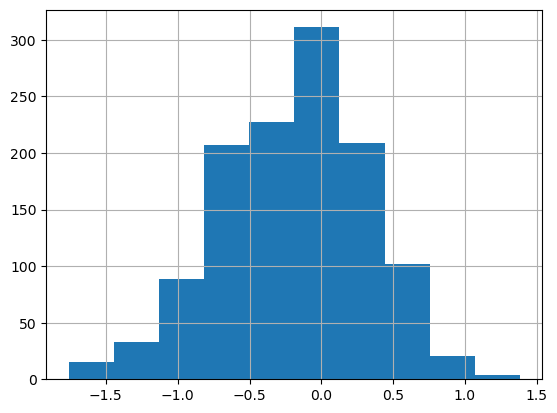

In [367]:
rna["AAK1"].hist()

In [359]:
temp = rna.loc[["TCGA-3C-AALI", "TCGA-3C-AALJ"], ["AAK1", "AATK", "ABCB1"]]
temp

# rna.head()

sample,AAK1,AATK,ABCB1
TCGA-3C-AALI,-0.263717,-0.069315,-1.553488
TCGA-3C-AALJ,-0.840417,0.357285,-2.448588
